In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip
!rm Covid_Data_GradientCrescent.zip
!rm -rf /content/all/test/pneumonia_vir
!rm -rf /content/all/train/pneumonia_vir

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 105MB/s] 
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil

Using TensorFlow backend.


In [ ]:
DATASET_PATH = '/content/all/train'
test_dir = '/content/all/test'
IMAGE_SIZE = (150, 150)
NUM_CLASSES = 3
BATCH_SIZE = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 20
LEARNING_RATE = 0.00005 
FOLDS = 10

In [ ]:
class DirectoryStratifiedKFold:
  
  def __init__(self, directory, k, fold_dir = '/content'):
    self.directory = directory
    self.k = k
    self.fold_dir = fold_dir
    self.labels = os.listdir(directory) 
    self.files = []

    for label in self.labels:
      self.files.append(os.listdir(directory + '/' + label))

  def gen_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    sub_train = '/train'
    sub_test = '/test'
    if not os.path.isdir(fold):
      os.mkdir(fold)
      os.mkdir(fold + sub_train)
      os.mkdir(fold + sub_test)
      for label, files in zip(self.labels, self.files):
        os.mkdir(fold + sub_train + '/' + label)
        os.mkdir(fold + sub_test + '/' + label)
        lower = (n) * (len(files) / self.k)
        upper = (n + 1) * (len(files) / self.k)
        for i, file in enumerate(files):
          if (lower <= i and i < upper):
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_test + '/' + label + '/' + file)
          else:
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_train + '/' + label + '/' + file)

    return (fold + sub_train, fold + sub_test)

  def del_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    if os.path.isdir(fold):
      shutil.rmtree(fold)

  def shuffle(self):
    for label in self.files:
      np.random.shuffle(label)


In [ ]:
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   fill_mode='constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Add, Input, Conv2D, MaxPooling2D, UpSampling2D

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

transfer = models.Sequential([Conv2D(512, (3, 3), activation='relu', padding='same'),
                              Conv2D(512, (3, 3), activation='relu', padding='same'),
                              Conv2D(512, (3, 3), activation='relu', padding='same'),
                              MaxPooling2D((2, 2), (2, 2)),
                              Conv2D(512, (3, 3), activation='relu', padding='same'),
                              Conv2D(512, (3, 3), activation='relu', padding='same'),
                              Conv2D(512, (3, 3), activation='relu', padding='same'),
                              MaxPooling2D((2, 2), (2, 2))])

predictor = models.Sequential([Flatten(),
                               Dense(256, activation='relu'),
                               Dense(3, activation='softmax')])

base = conv_base.output
addition = transfer(base)
skip = Add()([base, addition])
predictions = predictor(skip)

model = models.Model(inputs = conv_base.input, outputs = predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

weights = model.get_weights()

test_batches = train_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

Found 27 images belonging to 3 classes.


In [ ]:
def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over '+ str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# shutil.rmtree('__tempfold__3')

In [ ]:
kfold = DirectoryStratifiedKFold(DATASET_PATH, FOLDS)
kfold.shuffle()
results = []
evaluations = []


 Fold 0 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/18 [==============================] - 5s 298ms/step - loss: 1.0525 - acc: 0.4667 - val_loss: 0.8162 - val_acc: 0.6500
Epoch 2/20
18/18 [==============================] - 5s 261ms/step - loss: 0.9573 - acc: 0.5556 - val_loss: 0.4900 - val_acc: 0.7500
Epoch 3/20
18/18 [==============================] - 5s 262ms/step - loss: 0.7738 - acc: 0.5944 - val_loss: 0.5528 - val_acc: 0.5500
Epoch 4/20
18/18 [==============================] - 5s 265ms/step - loss: 0.7227 - acc: 0.6444 - val_loss: 0.3262 - val_acc: 0.9500
Epoch 5/20
18/18 [==============================] - 5s 264ms/step - loss: 0.6193 - acc: 0.7556 - val_loss: 0.4626 - val_acc: 0.9000
Epoch 6/20
18/18 [==============================] - 5s 263ms/step - loss: 0.5602 - acc: 0.7722 - val_loss: 0.3196 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 5s 263ms/step - loss: 0.3784 - acc: 0.8500 - val_loss: 0.1252 - val_acc: 0.9500
Epoch 8/20
18/18 [==============================] - 5s 266ms/step - loss: 0.3200 - acc:

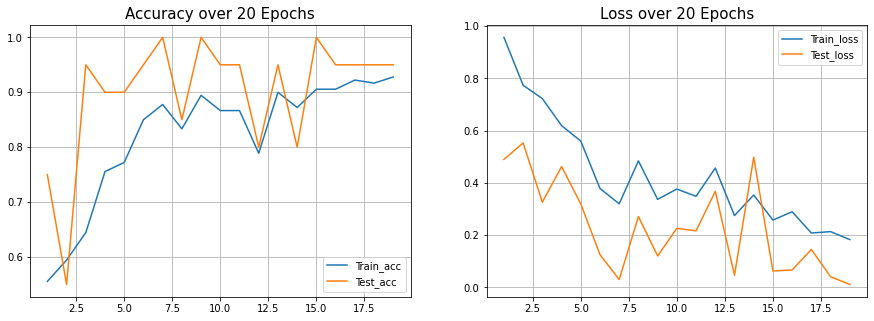

[0.030041998252272606, 0.8888888955116272]

 Fold 1 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 271ms/step - loss: 1.1236 - acc: 0.3833 - val_loss: 1.0679 - val_acc: 0.4500
Epoch 2/20
18/18 [==============================] - 5s 270ms/step - loss: 1.0232 - acc: 0.5333 - val_loss: 0.8871 - val_acc: 0.6000
Epoch 3/20
18/18 [==============================] - 5s 264ms/step - loss: 1.0148 - acc: 0.4722 - val_loss: 0.9934 - val_acc: 0.4500
Epoch 4/20
18/18 [==============================] - 5s 264ms/step - loss: 0.8316 - acc: 0.5611 - val_loss: 1.0870 - val_acc: 0.5500
Epoch 5/20
18/18 [==============================] - 5s 265ms/step - loss: 0.7104 - acc: 0.6944 - val_loss: 0.7863 - val_acc: 0.6500
Epoch 6/20
18/18 [==============================] - 5s 265ms/step - loss: 0.7245 - acc: 0.6833 - val_loss: 1.1658 - val_acc: 0.6500
Epoch 7/20
18/18 [==============================] - 5s 267ms/step - loss:

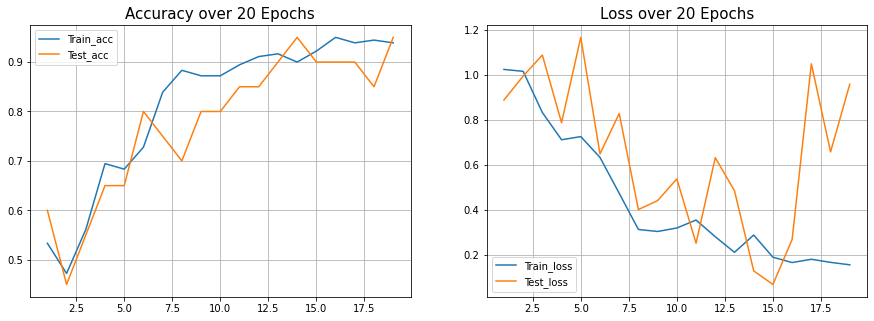

[0.018426259979605675, 0.8888888955116272]

 Fold 2 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 276ms/step - loss: 1.2180 - acc: 0.3000 - val_loss: 0.9504 - val_acc: 0.4000
Epoch 2/20
18/18 [==============================] - 5s 265ms/step - loss: 0.9464 - acc: 0.5556 - val_loss: 1.0209 - val_acc: 0.6000
Epoch 3/20
18/18 [==============================] - 5s 267ms/step - loss: 0.8364 - acc: 0.6111 - val_loss: 1.1455 - val_acc: 0.6500
Epoch 4/20
18/18 [==============================] - 5s 272ms/step - loss: 0.7710 - acc: 0.6222 - val_loss: 0.9369 - val_acc: 0.6000
Epoch 5/20
18/18 [==============================] - 5s 262ms/step - loss: 0.6545 - acc: 0.7111 - val_loss: 0.8299 - val_acc: 0.7000
Epoch 6/20
18/18 [==============================] - 5s 268ms/step - loss: 0.5364 - acc: 0.7611 - val_loss: 0.8392 - val_acc: 0.6000
Epoch 7/20
18/18 [==============================] - 5s 263ms/step - loss:

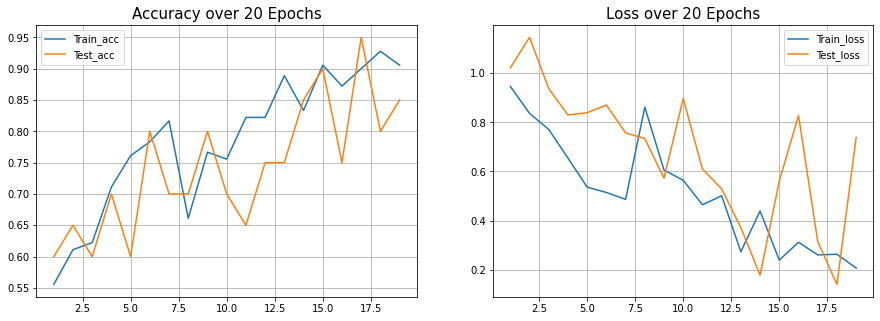

[0.06222955510020256, 0.7407407164573669]

 Fold 3 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 271ms/step - loss: 1.1223 - acc: 0.4222 - val_loss: 0.7007 - val_acc: 0.6500
Epoch 2/20
18/18 [==============================] - 5s 265ms/step - loss: 1.0164 - acc: 0.4778 - val_loss: 1.0734 - val_acc: 0.4500
Epoch 3/20
18/18 [==============================] - 5s 265ms/step - loss: 0.8095 - acc: 0.6444 - val_loss: 0.7056 - val_acc: 0.5500
Epoch 4/20
18/18 [==============================] - 5s 262ms/step - loss: 0.6528 - acc: 0.6889 - val_loss: 0.4207 - val_acc: 0.8000
Epoch 5/20
18/18 [==============================] - 5s 263ms/step - loss: 0.5976 - acc: 0.7944 - val_loss: 0.4897 - val_acc: 0.7000
Epoch 6/20
18/18 [==============================] - 5s 263ms/step - loss: 0.6699 - acc: 0.7111 - val_loss: 0.6845 - val_acc: 0.7500
Epoch 7/20
18/18 [==============================] - 5s 265ms/step - loss: 

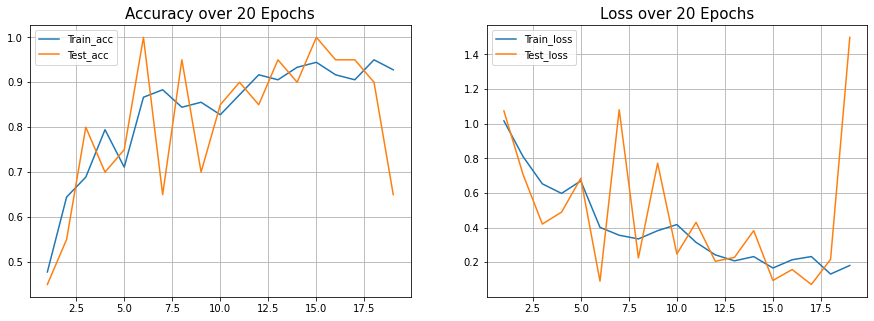

[0.41405606269836426, 0.6666666865348816]

 Fold 4 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 275ms/step - loss: 1.1000 - acc: 0.4722 - val_loss: 1.0519 - val_acc: 0.5000
Epoch 2/20
18/18 [==============================] - 5s 267ms/step - loss: 0.9785 - acc: 0.4833 - val_loss: 0.6999 - val_acc: 0.6500
Epoch 3/20
18/18 [==============================] - 5s 265ms/step - loss: 0.7016 - acc: 0.6778 - val_loss: 0.2179 - val_acc: 0.8500
Epoch 4/20
18/18 [==============================] - 5s 264ms/step - loss: 0.6519 - acc: 0.6944 - val_loss: 0.4960 - val_acc: 0.7500
Epoch 5/20
18/18 [==============================] - 5s 262ms/step - loss: 0.6967 - acc: 0.7167 - val_loss: 0.7096 - val_acc: 0.5500
Epoch 6/20
18/18 [==============================] - 5s 260ms/step - loss: 0.4912 - acc: 0.8222 - val_loss: 0.1910 - val_acc: 0.9500
Epoch 7/20
18/18 [==============================] - 5s 261ms/step - loss: 

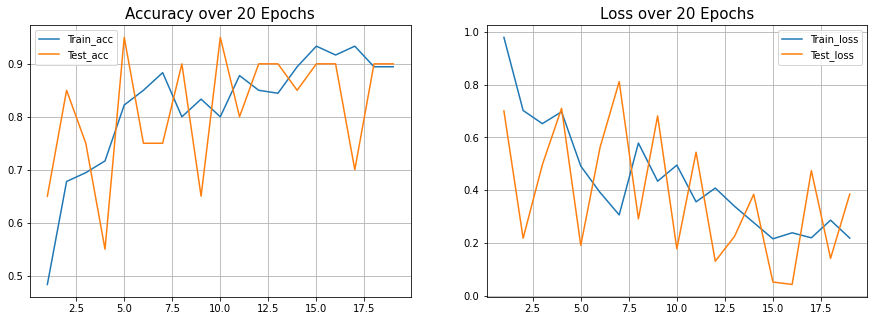

[0.21985921263694763, 0.7037037014961243]

 Fold 5 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 267ms/step - loss: 1.1430 - acc: 0.4611 - val_loss: 1.0519 - val_acc: 0.6000
Epoch 2/20
18/18 [==============================] - 5s 259ms/step - loss: 0.8575 - acc: 0.6167 - val_loss: 0.9118 - val_acc: 0.6000
Epoch 3/20
18/18 [==============================] - 5s 261ms/step - loss: 0.7182 - acc: 0.6944 - val_loss: 0.8803 - val_acc: 0.7500
Epoch 4/20
18/18 [==============================] - 5s 261ms/step - loss: 0.6167 - acc: 0.7889 - val_loss: 0.5556 - val_acc: 0.8500
Epoch 5/20
18/18 [==============================] - 5s 261ms/step - loss: 0.5668 - acc: 0.8167 - val_loss: 0.3133 - val_acc: 0.8000
Epoch 6/20
18/18 [==============================] - 5s 263ms/step - loss: 0.6898 - acc: 0.6889 - val_loss: 0.7079 - val_acc: 0.8000
Epoch 7/20
18/18 [==============================] - 5s 260ms/step - loss: 

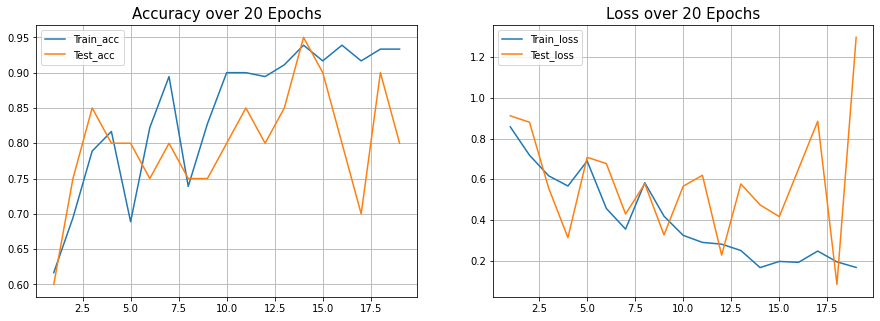

[0.00945039838552475, 0.7777777910232544]

 Fold 6 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 268ms/step - loss: 1.1272 - acc: 0.4278 - val_loss: 1.0921 - val_acc: 0.3500
Epoch 2/20
18/18 [==============================] - 5s 265ms/step - loss: 1.0481 - acc: 0.4444 - val_loss: 0.8125 - val_acc: 0.6000
Epoch 3/20
18/18 [==============================] - 5s 262ms/step - loss: 0.9220 - acc: 0.5778 - val_loss: 1.0225 - val_acc: 0.5000
Epoch 4/20
18/18 [==============================] - 5s 262ms/step - loss: 0.7791 - acc: 0.6167 - val_loss: 0.8225 - val_acc: 0.6000
Epoch 5/20
18/18 [==============================] - 5s 262ms/step - loss: 0.6034 - acc: 0.7389 - val_loss: 0.9976 - val_acc: 0.7000
Epoch 6/20
18/18 [==============================] - 5s 266ms/step - loss: 0.6551 - acc: 0.7500 - val_loss: 0.4640 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 5s 266ms/step - loss: 

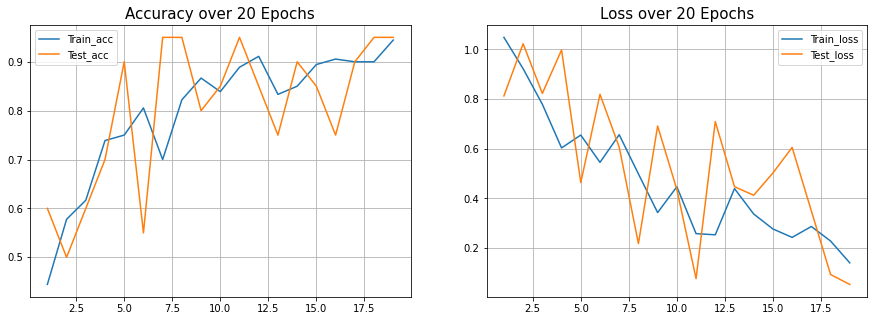

[0.11910895258188248, 0.8148148059844971]

 Fold 7 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 269ms/step - loss: 1.0915 - acc: 0.4500 - val_loss: 0.9862 - val_acc: 0.4000
Epoch 2/20
18/18 [==============================] - 5s 260ms/step - loss: 0.9273 - acc: 0.5500 - val_loss: 0.5487 - val_acc: 0.5500
Epoch 3/20
18/18 [==============================] - 5s 265ms/step - loss: 0.7925 - acc: 0.6222 - val_loss: 0.7835 - val_acc: 0.6500
Epoch 4/20
18/18 [==============================] - 5s 264ms/step - loss: 0.6888 - acc: 0.6833 - val_loss: 0.7219 - val_acc: 0.8000
Epoch 5/20
18/18 [==============================] - 5s 270ms/step - loss: 0.5704 - acc: 0.7111 - val_loss: 0.7895 - val_acc: 0.7500
Epoch 6/20
18/18 [==============================] - 5s 271ms/step - loss: 0.4755 - acc: 0.7944 - val_loss: 0.6449 - val_acc: 0.7000
Epoch 7/20
18/18 [==============================] - 5s 268ms/step - loss: 

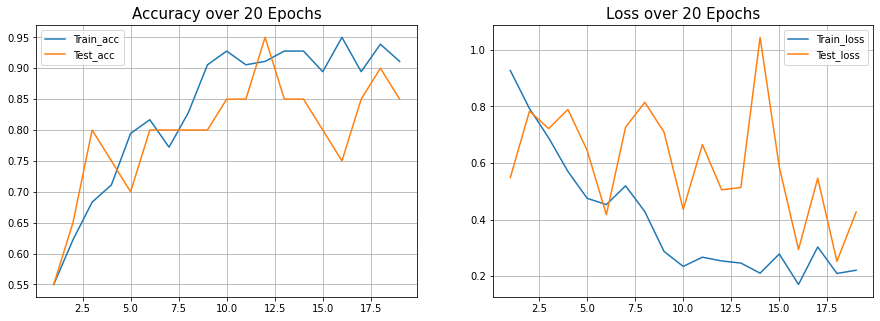

[0.14191867411136627, 0.7777777910232544]

 Fold 8 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 273ms/step - loss: 1.2076 - acc: 0.3611 - val_loss: 1.0960 - val_acc: 0.6000
Epoch 2/20
18/18 [==============================] - 5s 264ms/step - loss: 1.0123 - acc: 0.4944 - val_loss: 1.0759 - val_acc: 0.6500
Epoch 3/20
18/18 [==============================] - 5s 264ms/step - loss: 0.8374 - acc: 0.7056 - val_loss: 0.5723 - val_acc: 0.8500
Epoch 4/20
18/18 [==============================] - 5s 261ms/step - loss: 0.6431 - acc: 0.7444 - val_loss: 0.8329 - val_acc: 0.7000
Epoch 5/20
18/18 [==============================] - 5s 262ms/step - loss: 0.5383 - acc: 0.7944 - val_loss: 0.4896 - val_acc: 0.7500
Epoch 6/20
18/18 [==============================] - 5s 263ms/step - loss: 0.4684 - acc: 0.8500 - val_loss: 0.1646 - val_acc: 0.9500
Epoch 7/20
18/18 [==============================] - 5s 261ms/step - loss: 

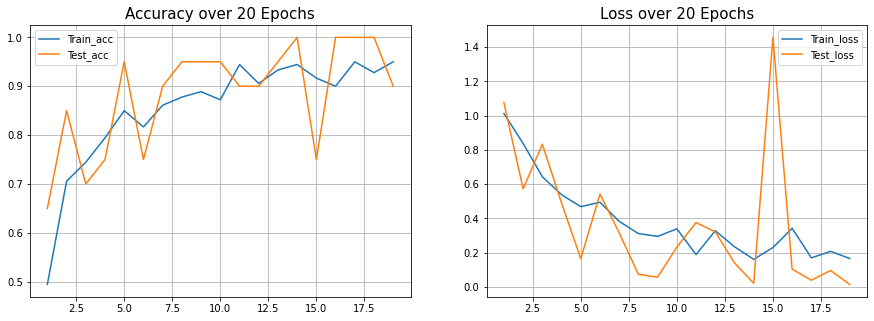

[0.19076547026634216, 0.8888888955116272]

 Fold 9 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 5s 277ms/step - loss: 1.1815 - acc: 0.3944 - val_loss: 1.0754 - val_acc: 0.5500
Epoch 2/20
18/18 [==============================] - 5s 269ms/step - loss: 0.8986 - acc: 0.5833 - val_loss: 1.3337 - val_acc: 0.5500
Epoch 3/20
18/18 [==============================] - 5s 265ms/step - loss: 0.8521 - acc: 0.6056 - val_loss: 0.5363 - val_acc: 0.6500
Epoch 4/20
18/18 [==============================] - 5s 266ms/step - loss: 0.7138 - acc: 0.7444 - val_loss: 0.4743 - val_acc: 0.7500
Epoch 5/20
18/18 [==============================] - 5s 267ms/step - loss: 0.5669 - acc: 0.7889 - val_loss: 0.2942 - val_acc: 0.8000
Epoch 6/20
18/18 [==============================] - 5s 268ms/step - loss: 0.4445 - acc: 0.8500 - val_loss: 0.7498 - val_acc: 0.6500
Epoch 7/20
18/18 [==============================] - 5s 267ms/step - loss: 

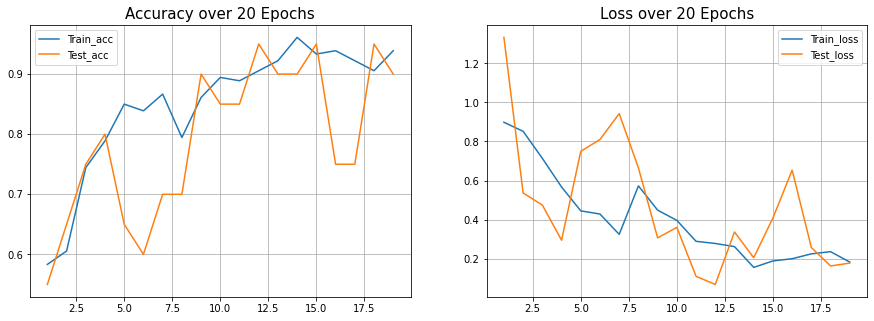

[0.6852130889892578, 0.7777777910232544]


In [ ]:
for k in range(FOLDS):
  model.set_weights(weights)
  train, test = kfold.gen_fold(k)

  print('\n', 'Fold', k, '\n')

  train_batches = train_datagen.flow_from_directory(train,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')
  valid_batches = train_datagen.flow_from_directory(test,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

  STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
  STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
  model.set_weights(weights)
  result = model.fit_generator(train_batches,
                            steps_per_epoch =STEP_SIZE_TRAIN,
                            validation_data = valid_batches,
                            validation_steps = STEP_SIZE_VALID,
                            epochs= NUM_EPOCHS)
  evaluation = model.evaluate_generator(test_batches)

  results.append(result)
  evaluations.append(evaluation)

  plot_acc_loss(result, 20)
  print(evaluation)

  kfold.del_fold(k)

In [ ]:
np.mean(np.array(evaluations)[:,1])

0.7925925970077514

0.7777777791023255